In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors, ticker

import pandas as pd
import numpy as np
import scipy as sp
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
import arviz as az
import seaborn as sns

import kinesis as kn
import gapipes as gp

plt.style.use('kinesis.mplstyle')
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)
plt.rc('legend', fontsize=12)

In [113]:
df = pd.read_csv("../data/beehive_dr2.csv")
b0 = np.median(df.g.icrs.cartesian.xyz.value, axis=1)
with np.printoptions(formatter=dict(float=lambda x:'{:7.3f}'.format(x))):
    print(f'b0 = {b0} pc')

def add_cartesian_xv(df):
    df['x'], df['y'], df['z'] = df.g.icrs.cartesian.xyz.value
    df['vx'], df['vy'], df['vz'] = df.g.icrs.velocity.d_xyz.value
    df['gx'], df['gy'], df['gz'] = df.g.galactic.cartesian.xyz.value
    df['gvx'], df['gvy'], df['gvz'] = df.g.galactic.velocity.d_xyz.value

add_cartesian_xv(df)

b0 = [-112.439 134.061  62.991] pc


In [5]:
# Parameters
fn = "../report/beehive-dr2/fit.pickle"


In [6]:
fit = kn.load_stanfit(fn)
azfit = az.from_pystan(fit)

v = azfit
for ck, cv in kn.decompose_T(v.posterior['T_param']).items():
    v.posterior[ck]=cv
sigv_samples, Omega_samples = v.posterior['sigv'],  v.posterior['Omega']
Sigma_samples = np.einsum('cni,cnij,cnj->cnij', sigv_samples, Omega_samples, sigv_samples)
v.posterior['Sigma'] = ('chain','draw','Simga_dim_0','Sigma_dim_1'), Sigma_samples
v.posterior['Sigma_gal'] = ('chain','draw','Simga_dim_0','Sigma_dim_1'), kn.rotate_T_to_galactic(Sigma_samples)
v.posterior['T_param_gal'] = ('chain','draw','dim0','dim1'), kn.rotate_T_to_galactic(v.posterior['T_param'])
for ck, cv in kn.decompose_T(v.posterior['T_param_gal']).items():
    v.posterior[ck+'_gal']  = cv

## Table of summary statistics

In [7]:
from IPython.display import display, HTML
var_names = list(azfit.posterior.data_vars.keys())
var_names.remove('probmem')
var_names.remove('a_model')
var_names.remove('rv_model')
with pd.option_context("display.max_rows", 100):
    display(HTML(az.summary(azfit, var_names).to_html()))

/data/vault/soh/projects/opensource/arviz/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],0.867,0.054,0.767,0.968,0.001,0.001,4046.0,4012.0,4041.0,3071.0,1.0
v0[1],48.707,0.064,48.594,48.831,0.001,0.001,4394.0,4394.0,4408.0,2868.0,1.0
v0[2],0.930,0.032,0.869,0.988,0.000,0.000,4199.0,4198.0,4200.0,2956.0,1.0
sigv[0],0.463,0.068,0.338,0.589,0.001,0.001,2250.0,2250.0,2237.0,2800.0,1.0
sigv[1],1.001,0.069,0.876,1.133,0.001,0.001,2812.0,2783.0,2834.0,3061.0,1.0
sigv[2],0.500,0.051,0.405,0.593,0.001,0.001,2147.0,2147.0,2141.0,2715.0,1.0
"Omega[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"Omega[0,1]",0.459,0.117,0.242,0.676,0.002,0.001,3773.0,3558.0,3760.0,2837.0,1.0
"Omega[0,2]",-0.022,0.248,-0.431,0.470,0.006,0.004,1873.0,1873.0,1964.0,2124.0,1.0
"Omega[1,0]",0.459,0.117,0.242,0.676,0.002,0.001,3773.0,3558.0,3760.0,2837.0,1.0


## Mean velocity

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


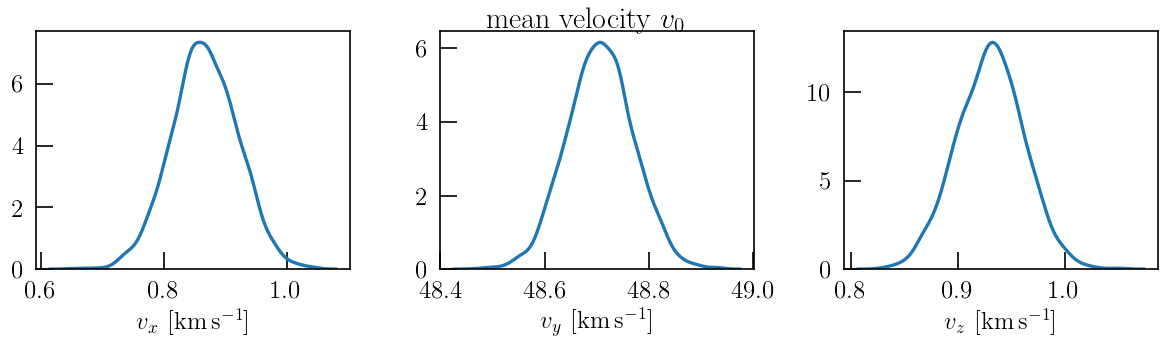

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
v = azfit
for i, cax in enumerate(ax):
    sns.kdeplot(
        v.posterior["v0"].stack(samples=["chain", "draw"])[i],
        ax=cax,
        legend=False,
    )
ax[0].set_xlabel("$v_x$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[1].set_xlabel("$v_y$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[2].set_xlabel("$v_z$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
fig.suptitle('mean velocity $v_0$');
fig.tight_layout()

## Velocity dispersion

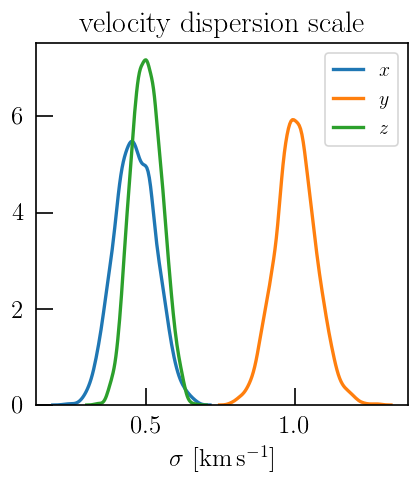

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
v = azfit
cax = ax
for i, axis in zip(range(3), ['x','y','z']):
    sns.kdeplot(
        v.posterior["sigv"].stack(samples=["chain", "draw"])[i],
        ax=cax,
        label='${}$'.format(axis),
        legend=False,
    )
ax.set_xlabel("$\sigma$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax.legend();
ax.set_title('velocity dispersion scale');

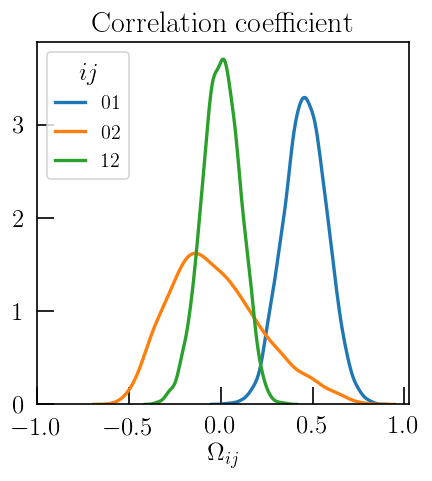

In [10]:
fig, ax = plt.subplots(figsize=(4,4))
Omega_offdiag = (
    azfit.posterior["Omega"].stack(i=["chain", "draw"]).values[[0, 0, 1], [1, 2, 2], :]
)
for val, label in zip(Omega_offdiag, ["01", "02", "12"]):
    sns.kdeplot(val, label=label, ax=ax)
ax.set_xlabel('$\Omega_{ij}$')
ax.set_title('Correlation coefficient');
ax.set_xticks([-1,-0.5,0,0.5,1]);
ax.legend(title='$ij$');

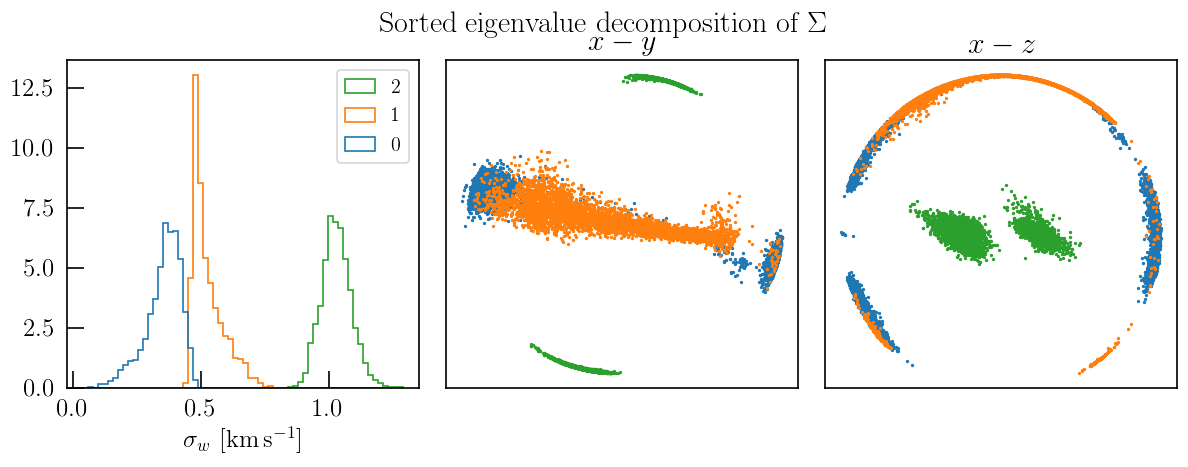

In [11]:
eig = kn.EigenvalueDecomposition(
    azfit.posterior['Sigma'].stack(samples=['chain','draw']).T)

fig, ax = plt.subplots(1, 3, figsize=(10,4))
ax[0].hist(np.sqrt(eig.w), density=True, bins=64, histtype='step', label=['0','1','2']);
for i in range(3):
    ax[1].scatter(eig.v[:,0,i], eig.v[:,1,i],s=1);
    ax[2].scatter(eig.v[:,0,i], eig.v[:,2,i],s=1);
fig.suptitle("Sorted eigenvalue decomposition of $\Sigma$")
ax[0].set_xlabel("$\sigma_w$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
def cleanticks(cax):
    cax.set_xticks([])
    cax.set_yticks([])
cleanticks(ax[1])
cleanticks(ax[2])
ax[1].set_title('$x-y$')
ax[2].set_title('$x-z$');
ax[0].legend()
fig.tight_layout()

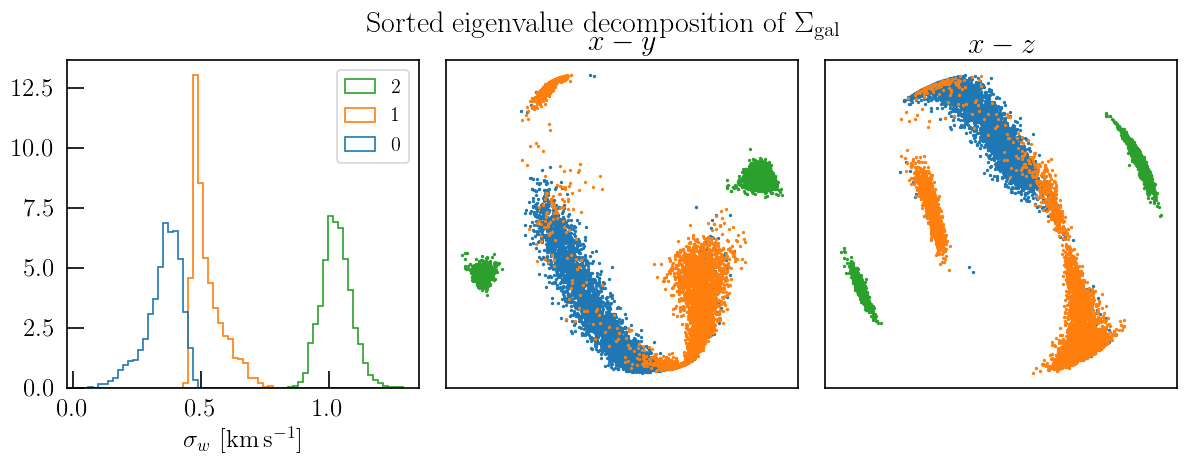

In [12]:
eig = kn.EigenvalueDecomposition(
    azfit.posterior['Sigma_gal'].stack(samples=['chain','draw']).T)

fig, ax = plt.subplots(1, 3, figsize=(10,4))
ax[0].hist(np.sqrt(eig.w), density=True, bins=64, histtype='step', label=['0','1','2']);
for i in range(3):
    ax[1].scatter(eig.v[:,0,i], eig.v[:,1,i],s=1);
    ax[2].scatter(eig.v[:,0,i], eig.v[:,2,i],s=1);
fig.suptitle("Sorted eigenvalue decomposition of $\Sigma_\mathrm{gal}$")
ax[0].set_xlabel("$\sigma_w$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
def cleanticks(cax):
    cax.set_xticks([])
    cax.set_yticks([])
cleanticks(ax[1])
cleanticks(ax[2])
ax[1].set_title('$x-y$')
ax[2].set_title('$x-z$');
ax[0].legend()
fig.tight_layout()

eigval mean = [  +0.354   +0.528   +1.030]
eigval std  = [  +0.070   +0.062   +0.059]


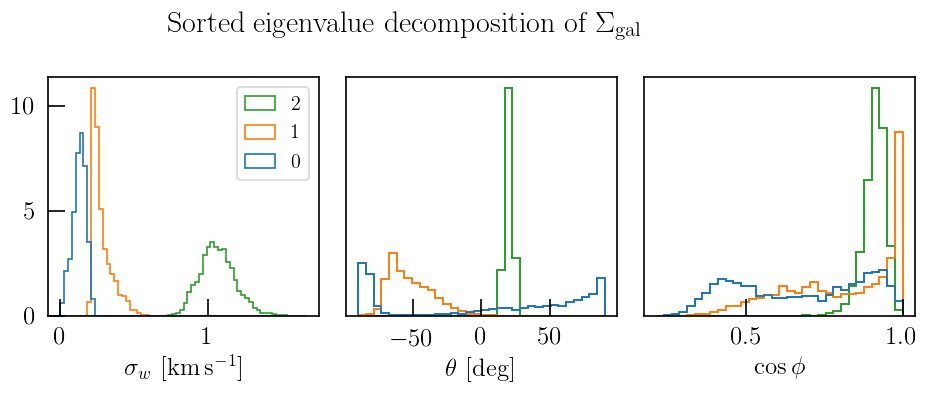

In [13]:
def cleanyticks(cax):
    cax.set_yticks([])

eig = kn.EigenvalueDecomposition(
    azfit.posterior['Sigma_gal'].stack(samples=['chain','draw']).T)
with np.printoptions(formatter=dict(float=lambda x:'{:+8.3f}'.format(x))):
    print('eigval mean = {}'.format(np.sqrt(eig.w).mean(axis=0), precision=3))
    print('eigval std  = {}'.format(np.sqrt(eig.w).std(axis=0), precision=3))

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].hist(eig.w, density=True, bins=64, histtype="step", label=["0", "1", "2"])
for i in range(3):
    ax[1].hist(
        eig.theta, histtype="step", density=True, bins=32, color=["C0", "C1", "C2"]
    )
    ax[2].hist(
        eig.cosphi, histtype="step", density=True, bins=32, color=["C0", "C1", "C2"]
    )
fig.suptitle("Sorted eigenvalue decomposition of $\Sigma_\mathrm{gal}$")
ax[0].set_xlabel("$\sigma_w$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
cleanyticks(ax[1])
cleanyticks(ax[2])
ax[1].set_xlabel(r"$\theta$ [deg]")
ax[2].set_xlabel("$\cos\phi$")

ax[0].legend()
fig.tight_layout(rect=[0.15, 0.15, 0.95, 0.9])

## Linear velocity field

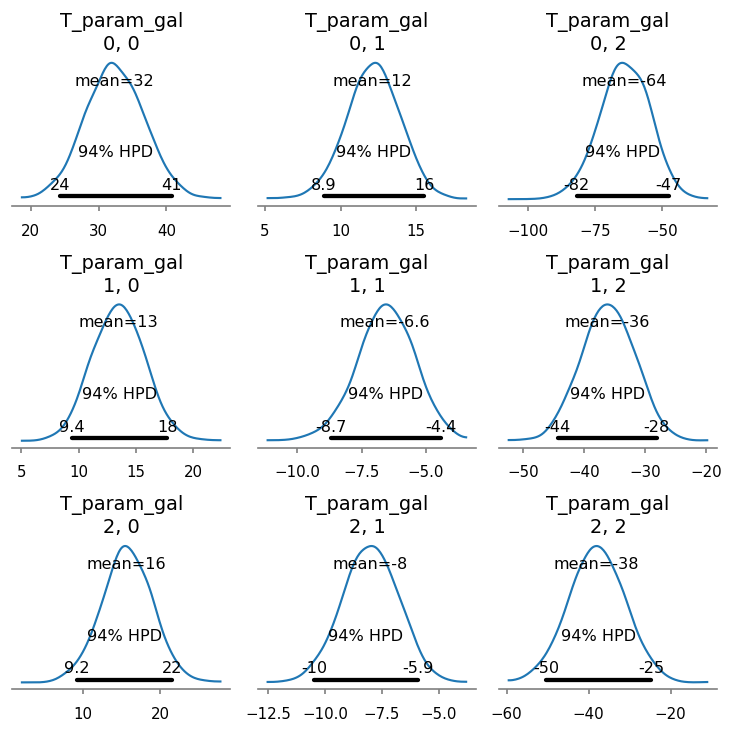

In [130]:
az.plot_posterior(azfit, 'T_param_gal', figsize=(6,6), textsize=9);

In [131]:
probmem_mean = fit["probmem"].mean(axis=0)
members = probmem_mean > 0.5
grp = cdf.groupby(members)
d = grp.get_group(True)

In [132]:
cc = coord.ICRS(*(b0*u.pc), *(fit['v0'].mean(axis=0)*u.km/u.s),
                representation_type='cartesian', differential_type='cartesian')
ccg = cc.transform_to(coord.Galactic)
v0_g = ccg.velocity.d_xyz.value
b0_g = ccg.cartesian.xyz.value

In [148]:
x, y = d.dropna(subset=['gvx'])[['gy','gvx']].values.T

In [150]:
sp.stats.pearsonr(x,y)

(0.4053016817945567, 1.2633476142326694e-10)

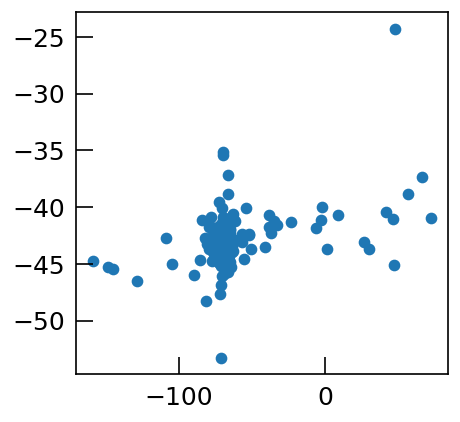

In [151]:
plt.scatter(x, y)

(-20, 20)

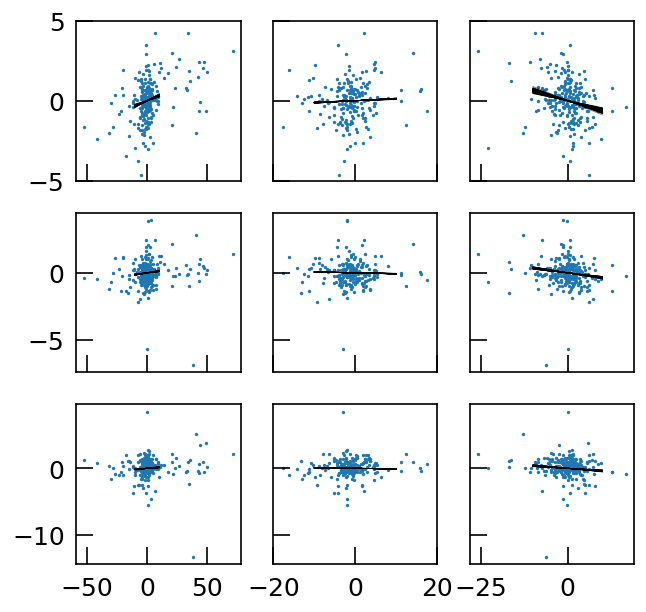

In [138]:
fig, ax = plt.subplots(3,3, figsize=(6,6), sharex='col', sharey='row')
i_random = np.random.randint(0, 4000, 100)
# ax[0,0].scatter(d['gx'],d['gvx'], s=1)
# ax[0,1].scatter(d['gy'],d['gvx'], s=1)
# ax[0,2].scatter(d['gz'],d['gvx'], s=1)
T = azfit.posterior['T_param_gal'].stack(i=['chain','draw']).values
xs=np.linspace(-10,10,101)
v0=fit['v0'].mean(axis=0)

for i_row, ylabel in zip([0,1,2], ['gvx','gvy','gvz']):
    for i_col, xlabel in zip([0,1,2], ['gx','gy','gz']):
        ax[i_row,i_col].scatter(d[xlabel]-b0_g[i_col],d[ylabel]-v0_g[i_row],s=1)
        for i in i_random:
            ax[i_row,i_col].plot(xs, T[i_row,i_col,i]/1e3*(xs), lw=.5, color='k',alpha=.5)
ax[0,0].set_ylim(-5,5)
ax[0,1].set_xlim(-20,20)

### Rotation

omega =  +42.362 +-    5.352


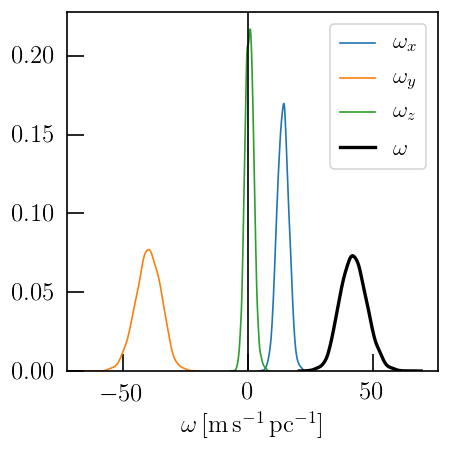

In [24]:
wT = azfit.posterior.stack(i=['chain','draw'])
fig, ax = plt.subplots(figsize=(4,4))
sns.distplot(wT["omegax_gal"], hist=False, kde_kws={'lw':1}, label=r'$\omega_x$')
sns.distplot(wT["omegay_gal"], hist=False, kde_kws={'lw':1}, label=r'$\omega_y$')
sns.distplot(wT["omegaz_gal"], hist=False, kde_kws={'lw':1}, label=r'$\omega_z$')
omega = np.sqrt(wT["omegax_gal"] ** 2 + wT["omegay_gal"] ** 2 + wT["omegaz_gal"] ** 2)
print(f"omega = {np.mean(omega.values):+8.3f} +- {np.std(omega.values):8.3f}")
sns.distplot(omega, hist=False, color='k', label=r'$\omega$')
ax.axvline(0, c='k', lw=1)
ax.legend(fontsize=14)
ax.set_xlabel(r'$\omega\,[\rm m\,\rm s^{-1}\,\rm pc^{-1}]$');
fig.tight_layout()

### Shear

eigval mean = [ -53.056   -6.525  +47.252]
eigval std  = [  +5.012   +1.513   +4.645]


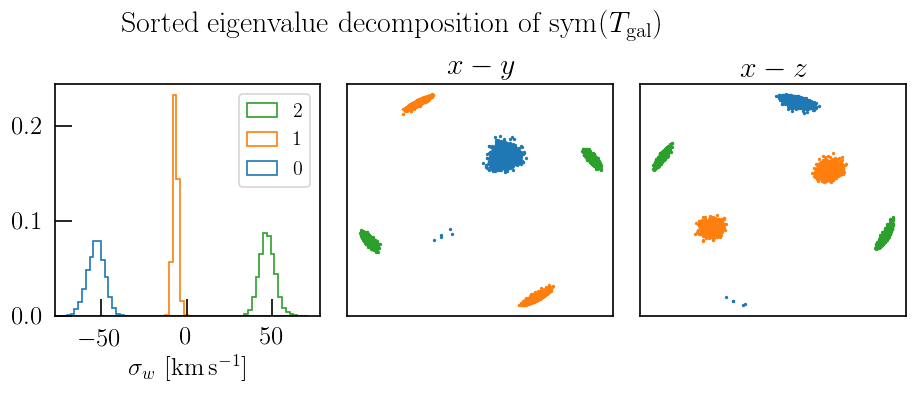

In [15]:
T_galactic = kn.rotate_T_to_galactic(fit["T_param"])
T_sym = (T_galactic + np.transpose(T_galactic, (0, 2, 1))) / 2.


eig = kn.EigenvalueDecomposition(T_sym)
with np.printoptions(formatter=dict(float=lambda x:'{:+8.3f}'.format(x))):
    print('eigval mean = {}'.format(eig.w.mean(axis=0), precision=3))
    print('eigval std  = {}'.format(eig.w.std(axis=0), precision=3))

fig, ax = plt.subplots(1, 3, figsize=(10,4))
ax[0].hist(eig.w, density=True, bins=64, histtype='step', label=['0','1','2']);
for i in range(3):
    ax[1].scatter(eig.v[:,0,i], eig.v[:,1,i],s=1);
    ax[2].scatter(eig.v[:,0,i], eig.v[:,2,i],s=1);
fig.suptitle(r"Sorted eigenvalue decomposition of $\mathrm{sym}(T_{\rm gal})$")
ax[0].set_xlabel("$\sigma_w$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
def cleanticks(cax):
    cax.set_xticks([])
    cax.set_yticks([])
cleanticks(ax[1])
cleanticks(ax[2])
ax[1].set_title('$x-y$')
ax[2].set_title('$x-z$');
ax[0].legend()
fig.tight_layout(rect=[0.15,0.15,0.95,0.95])

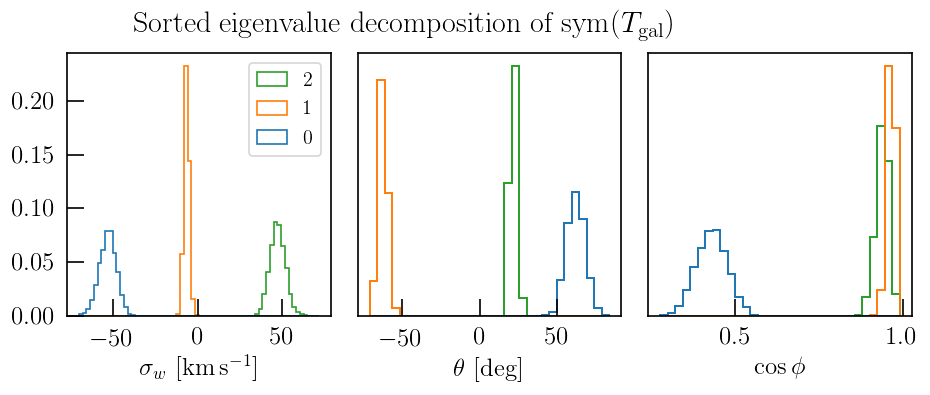

In [16]:
def cleanyticks(cax):
    cax.set_yticks([])

T_galactic = kn.rotate_T_to_galactic(fit["T_param"])
T_sym = (T_galactic + np.transpose(T_galactic, (0, 2, 1))) / 2.0
eig = kn.EigenvalueDecomposition(T_sym)


fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].hist(eig.w, density=True, bins=64, histtype="step", label=["0", "1", "2"])
for i in range(3):
    ax[1].hist(
        eig.theta, histtype="step", density=True, bins=32, color=["C0", "C1", "C2"]
    )
    ax[2].hist(
        eig.cosphi, histtype="step", density=True, bins=32, color=["C0", "C1", "C2"]
    )
fig.suptitle(r"Sorted eigenvalue decomposition of $\mathrm{sym}(T_{\rm gal})$")
ax[0].set_xlabel("$\sigma_w$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
cleanyticks(ax[1])
cleanyticks(ax[2])
ax[1].set_xlabel(r"$\theta$ [deg]")
ax[2].set_xlabel("$\cos\phi$")

ax[0].legend()
fig.tight_layout(rect=[0.15, 0.15, 0.95, 0.95])

eigval mean = [ -53.056   -6.525  +47.252]
eigval std  = [  +5.012   +1.513   +4.645]


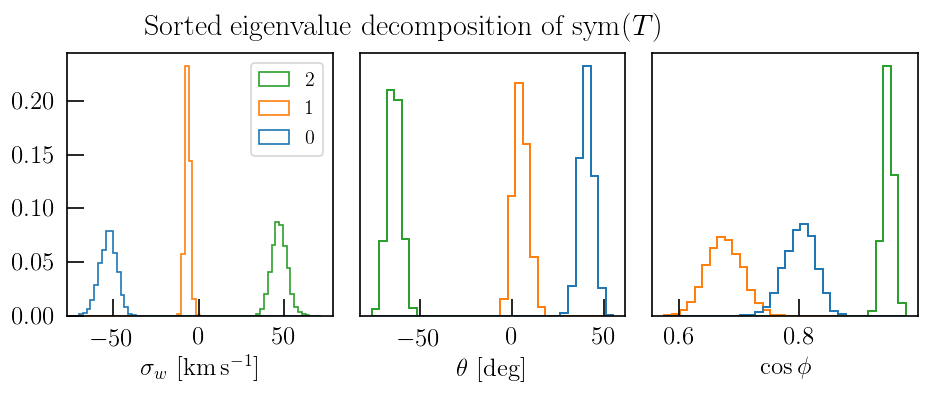

In [17]:
def cleanyticks(cax):
    cax.set_yticks([])

T_galactic = fit["T_param"]
T_sym = (T_galactic + np.transpose(T_galactic, (0, 2, 1))) / 2.
eig = kn.EigenvalueDecomposition(T_sym)
with np.printoptions(formatter=dict(float=lambda x:'{:+8.3f}'.format(x))):
    print('eigval mean = {}'.format(eig.w.mean(axis=0), precision=3))
    print('eigval std  = {}'.format(eig.w.std(axis=0), precision=3))

fig, ax = plt.subplots(1, 3, figsize=(10,4))
ax[0].hist(eig.w, density=True, bins=64, histtype='step', label=['0','1','2']);
for i in range(3):
    ax[1].hist(eig.theta, histtype='step', density=True, bins=32, color=['C0','C1','C2'])
    ax[2].hist(eig.cosphi, histtype='step', density=True, bins=32, color=['C0','C1','C2'])
fig.suptitle("Sorted eigenvalue decomposition of $\mathrm{sym}(T)$")
ax[0].set_xlabel("$\sigma_w$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
cleanyticks(ax[1])
cleanyticks(ax[2])
ax[1].set_xlabel(r'$\theta$ [deg]')
ax[2].set_xlabel('$\cos\phi$')

ax[0].legend()
fig.tight_layout(rect=[0.15,0.15,0.95,0.95])

## Membership

In [110]:
cdf = pd.DataFrame({'ra':fit.data['ra'], 'dec':fit.data['dec']})
cdf['parallax'], cdf['pmra'], cdf['pmdec'] = fit.data['a'].T
cdf.loc[fit.data['irv'], 'radial_velocity'] = fit.data['rv']
add_cartesian_xv(cdf)

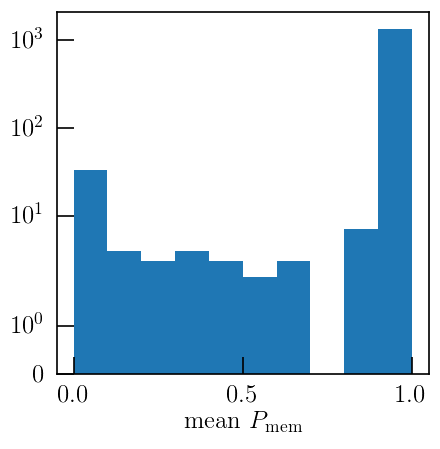

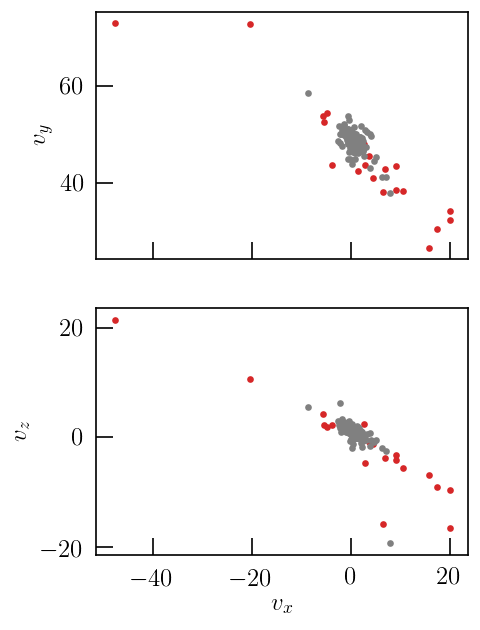

In [12]:
from matplotlib.gridspec import GridSpec

probmem_mean = fit["probmem"].mean(axis=0)
members = probmem_mean > 0.5
grp = cdf.groupby(members)

fig, ax = plt.subplots()
ax.hist(probmem_mean)
ax.set_yscale("symlog")
ax.set_xlabel(r"mean $P_{\rm mem}$")

with plt.rc_context(rc={"axes.prop_cycle": plt.cycler(color=["tab:red", "gray"])}):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6), sharex=True)
    # gs = GridSpec(4, 1)
    # ax1 = fig.add_subplot(gs[:3])
    # ax2 = fig.add_subplot(gs[3], sharex=ax1)
    for label, g in grp:
        ax1.scatter(g["vx"], g["vy"], s=9)
        ax2.scatter(g["vx"], g["vz"], s=9)
    ax2.set_xlabel(r'$v_x$')
    ax2.set_ylabel(r'$v_z$')
    ax1.set_ylabel(r'$v_y$')

In [116]:
cc = coord.ICRS(*(b0*u.pc), *(fit['v0'].mean(axis=0)*u.km/u.s),
                representation_type='cartesian', differential_type='cartesian')
ccg = cc.transform_to(coord.Galactic)
vx,vy,vz = ccg.velocity.d_xyz.value

In [117]:
ccg.cartesian

<CartesianRepresentation (x, y, z) in pc
    (-141.40047382, -68.13847679, 99.7279712)
 (has differentials w.r.t.: 's')>

In [123]:
dr= np.linalg.norm(df[['gx','gy','gz']].values - ccg.cartesian.xyz.value[None,:],axis=1)

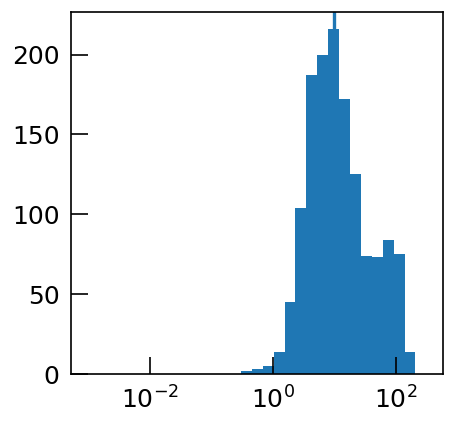

In [129]:
plt.hist(dr,np.logspace(-3,2.5,32))
plt.xscale('log');
plt.axvline(10)

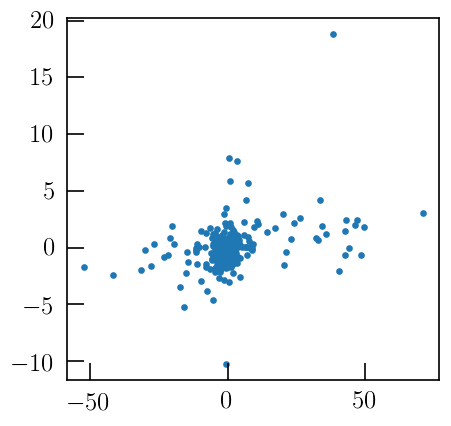

In [28]:
fig, ax = plt.subplots()
g = grp.get_group(True)    # remove outliers
ax.scatter(g["gx"]-ccg.cartesian.x.value, g["gvx"]-vx, s=9)
# ax.scatter(g["gy"]-ccg.cartesian.y.value, g["gvy"]-vy, s=9)


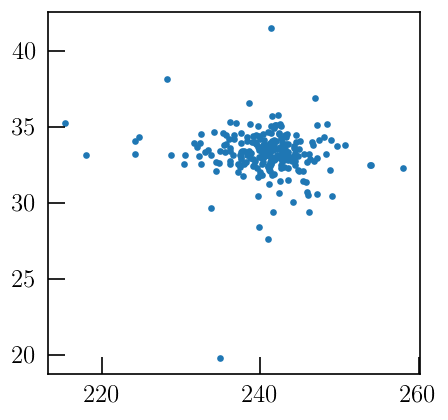

In [30]:
fig, ax = plt.subplots()
g = grp.get_group(True)    # remove outliers
ax.scatter(g["gz"]-ccg.cartesian.x.value, g["gvz"]-vx, s=9);
# ax.scatter(g["gy"]-ccg.cartesian.y.value, g["gvy"]-vy, s=9)

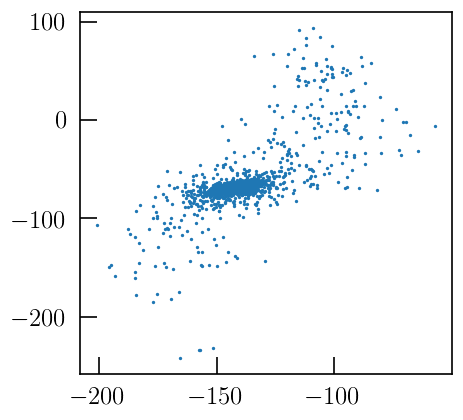

In [23]:
fig, ax =plt.subplots()
# ax.scatter(df['gx'],df['gy'],s=1)
ax.scatter(g['gx'],g['gy'],s=1)

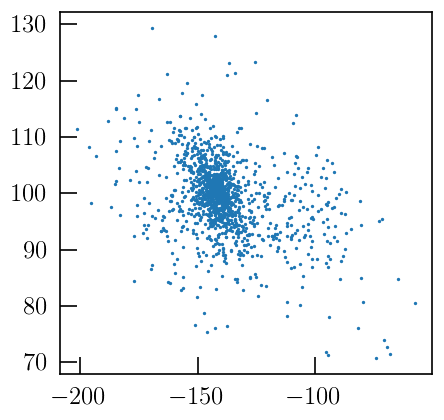

In [25]:
fig, ax =plt.subplots()
# ax.scatter(df['gx'],df['gy'],s=1)
ax.scatter(g['gx'],g['gz'],s=1)

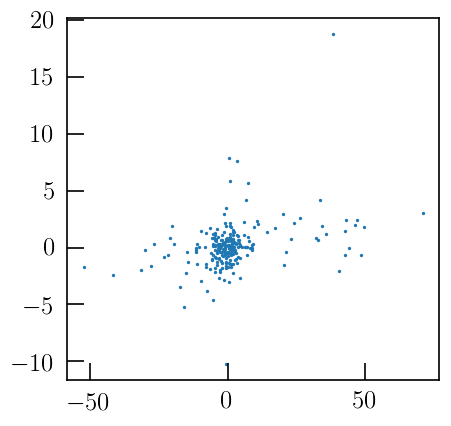

In [37]:
fig, ax =plt.subplots()
# ax.scatter(df['gx'],df['gy'],s=1)
ax.scatter(g['gx']-ccg.cartesian.x.value ,g['gvx']-vx,s=1)

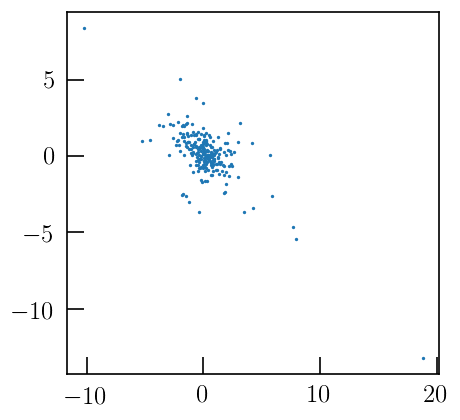

In [45]:
fig, ax =plt.subplots()
# ax.scatter(df['gx'],df['gy'],s=1)
ax.scatter(g['gvx']-vx ,g['gvz']-vz,s=1)
# ax.scatter(g['gvx']-vx ,g['gvy']-vy,s=1)

In [46]:
out_full = pd.read_csv("../data/hyades_full.csv")
df = out_full.loc[out_full['in_dr2'] == True].copy()
b0 = np.median(df.g.icrs.cartesian.xyz.value, axis=1)
with np.printoptions(formatter=dict(float=lambda x:'{:7.3f}'.format(x))):
    print(f'b0 = {b0} pc')

def add_cartesian_xv(df):
    df['x'], df['y'], df['z'] = df.g.icrs.cartesian.xyz.value
    df['vx'], df['vy'], df['vz'] = df.g.icrs.velocity.d_xyz.value
    df['gx'], df['gy'], df['gz'] = df.g.galactic.cartesian.xyz.value
    df['gvx'], df['gvy'], df['gvz'] = df.g.galactic.velocity.d_xyz.value
add_cartesian_xv(out_full)
add_cartesian_xv(df)

b0 = [ 17.268  41.643  13.606] pc


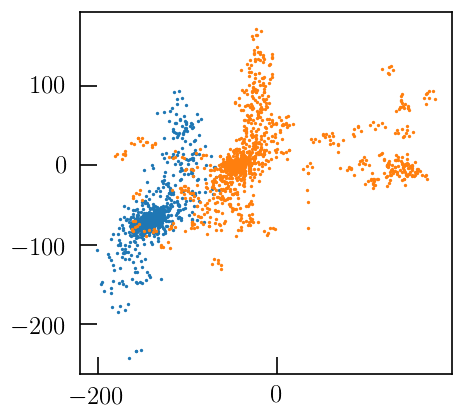

In [49]:
fig, ax =plt.subplots()
# ax.scatter(df['gx'],df['gy'],s=1)
ax.scatter(g['gx'],g['gy'],s=1)
ax.scatter(out_full['gx'],out_full['gy'],s=1)

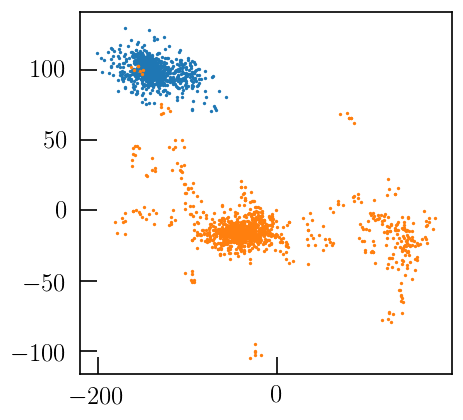

In [50]:
fig, ax =plt.subplots()
# ax.scatter(df['gx'],df['gy'],s=1)
ax.scatter(g['gx'],g['gz'],s=1)
ax.scatter(out_full['gx'],out_full['gz'],s=1)

In [56]:
azfit.posterior['T_param_gal'].stack(i=['chain','draw'])[2,2].mean()

<xarray.DataArray 'T_param_gal' ()>
array(-38.09985766)

<Quantity 99.7279712 pc>

In [87]:
sel = ~np.isnan(g['gvz'])
sp.stats.pearsonr(g['gz'][sel],g['gvz'][sel])

(-0.08478756346817945, 0.19719342743260992)

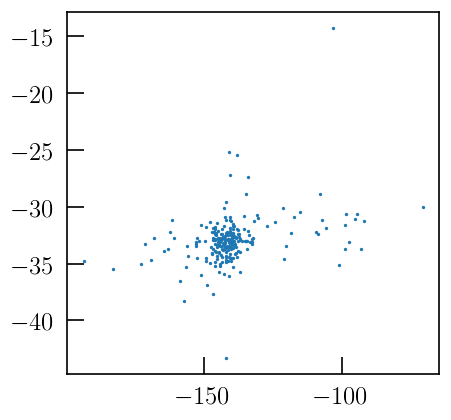

In [85]:
fig, ax =plt.subplots()
# ax.scatter(df['gx'],df['gy'],s=1)
ax.scatter(g['gx'],g['gvx']-vz,s=1)
# ax.scatter(out_full['gz'],out_full['gvz'],s=1)
# xx=np.linspace(-50,50)+ccg.cartesian.z.value
# plt.plot(xx, -38./1e3*(xx-ccg.cartesian.z.value), c='k',lw=1)
# plt.ylim(-5,5)

In [78]:
g['radial_velocity'].notnull().value_counts()

False    1113
True      233
Name: radial_velocity, dtype: int64

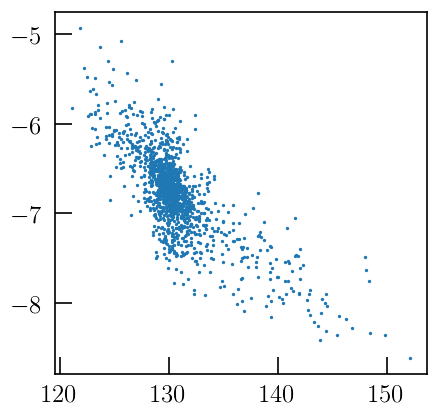

In [84]:
plt.scatter(g['ra'], g['pmra']/g['parallax'],s=1)

In [89]:
plt.rc('text', usetex=False)

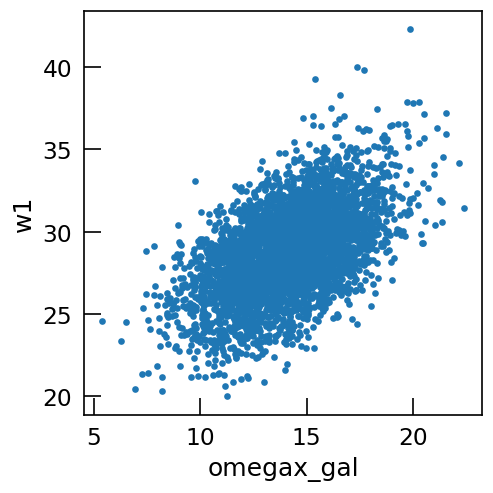

In [93]:
az.plot_pair(azfit, ['omegax_gal', 'w1'])

In [100]:
fit['a_model'].

(4000, 1393, 3)

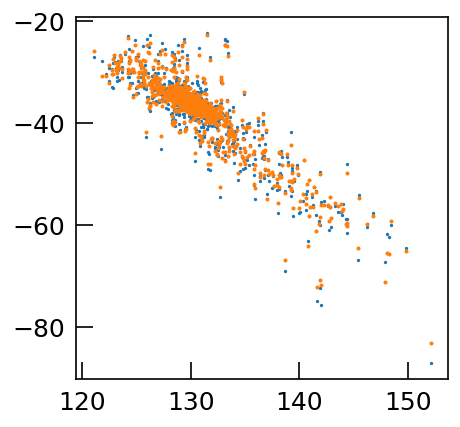

In [106]:
plt.scatter(g['ra'],g['pmra'],s=1)
a_model_mean = fit['a_model'].mean(axis=0,)
plt.scatter(fit.data['ra'][members], a_model_mean[:,1][members], s=2)

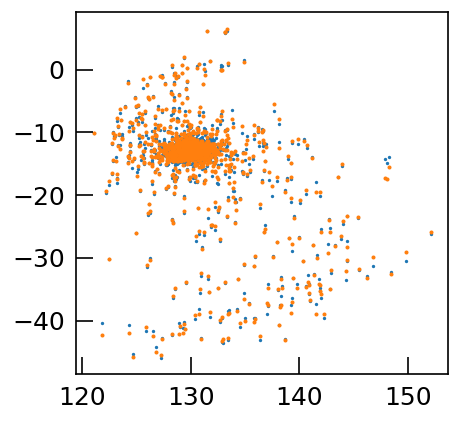

In [109]:
plt.scatter(g['ra'],g['pmdec'],s=1)
a_model_mean = fit['a_model'].mean(axis=0,)
plt.scatter(fit.data['ra'][members], a_model_mean[:,2][members], s=2)